In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Mirror Calibration

## Motivation

The goal here is to setup a flat surface mirror that will allow to

- Capture the appearance of the object under test from two different viewpoints
- Gather information about the environment
- Determine the pose of the camera

To know whe the pose of the camera we will solve a PnP problem, but before we need to place markers (AprilTags) onto the mirror.

The calibration consist in determinine the coordinates of the markers on the mirror.
You are welcome to do that in any way but we suggest using the camera you already calibrated to estimate the coordinates. This is what we will do in this notebook.

## Picking a mirror

Acquire a large, good quality mirror. Obviously a first surface mirror is better but because the cost would is too prohibitive for most, our pipeline support second surface mirrors. For second surface mirrors you will need to know

    1. the thickness of the medium in front of the reflective surface
    2. The type of medium and its refractive index (the default will be 1.53 for glass)
    
The mirror has to be large enough so that it will cover most if not all of the pictures you will take. This means it has to be significantly bigger than the object under test

## Generating markers

We now want generate a set of markers that we will glue on the mirror
Base on the size of mirror, the objects you will want to capture, resolution of camera you will need more or less markers. But don't place too many. Markers obfuscate the view of the environment so the more you have the lower the quality of the reconstructed environment will be.

We will generate a big grid of them you can print and cut how many as you need. A good rule of them is to make sure you have 6~7 markers visible for every picture you will take. You can print them as small as you want but they need to be clearly visible on the image so if you have a lower resolution camera you will need them bigger.

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from PIL import Image

from cv2 import aruco
from mirrorSDF.aruco import AruCrosshairField, ArucoCalibrationBoard
from mirrorSDF.optical_models import Lens, Mirror

In [27]:
NUM_MARKERS_TO_GENERATE = 24
MARKERS_TO_PRINT_FILENAME = '/tmp/crosshairs.png'

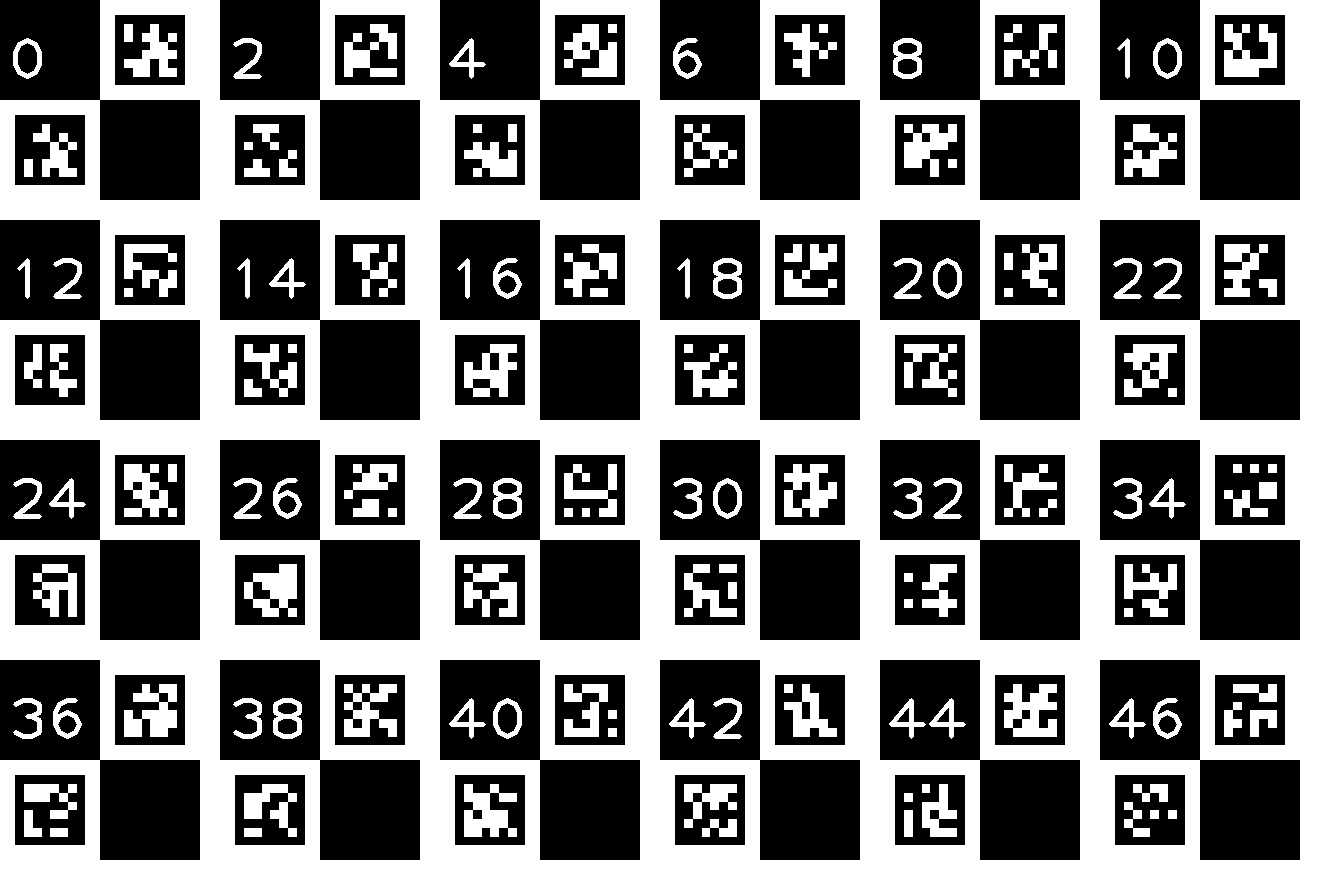

In [28]:
field = AruCrosshairField(NUM_MARKERS_TO_GENERATE, 0)
rendered = field.draw(6, 200)
image = Image.fromarray(rendered)

image.save(MARKERS_TO_PRINT_FILENAME)
image

## Gluing the markers

1. Print the markers above. The best is on somthing thin (avoid cardboard). Bonus points if it has an adhesive backing so that gluing is easier. Try to measure the thickness of the paper (or assume 0.1mm for regular paper)
1. Cut them individually. You should cut them in squares small enough that there is no white left around the solid black sqaures but not too much that there is no white around the smaller pixelated ones . If you are not using sticky paper consider rouding the corners(the white part!) to reduce the chance of them peeling off. You can round as much as you want as long as you leave some margin around the pixelated squares. The black solid ones (included the one with the number) are far game.
1. First make sure you clean the mirror very well before gluing, it's much easier this way
1. Glue the markers onto the mirror

**Important Notes**

1. **Place one marker at each corner of the mirror**. They will be used to define its size
2. **If your mirror is beveled only work within the flat portion of the mirror**. I.e. do not place the corner markers on the bevel.
2. **Leave space in at the center mirror without markers where you will place the object under test**. 
3. **Place two markers such that their midpoints is the center of the mirror**. This is where you will place your object.


# Printing a bootstraping pattern

To be able to determine the locations of the markers you placed, we need will need to take pictures of the mirror under many viewpoints. However for the optimization procedure to succeed we need to start with a good guess of the camera location for each picture.

The idea here will be to place another grid of markers(uncut so that their relative position is known)  at the center of the mirror (where you would place the object).
Since most printer print differently (and on different paper). You will need to measure
the width of a *single* tile of the checkerboard. For more accuracy you can measure more and then divide though.

**Important:**

- Do not glue that grid it's just for calibration
- Do not covery any markers or we won't be able to know its coordinates.
- Do not reuse the same grid as above or there will be conflicts. We will generate a new one here with different markers


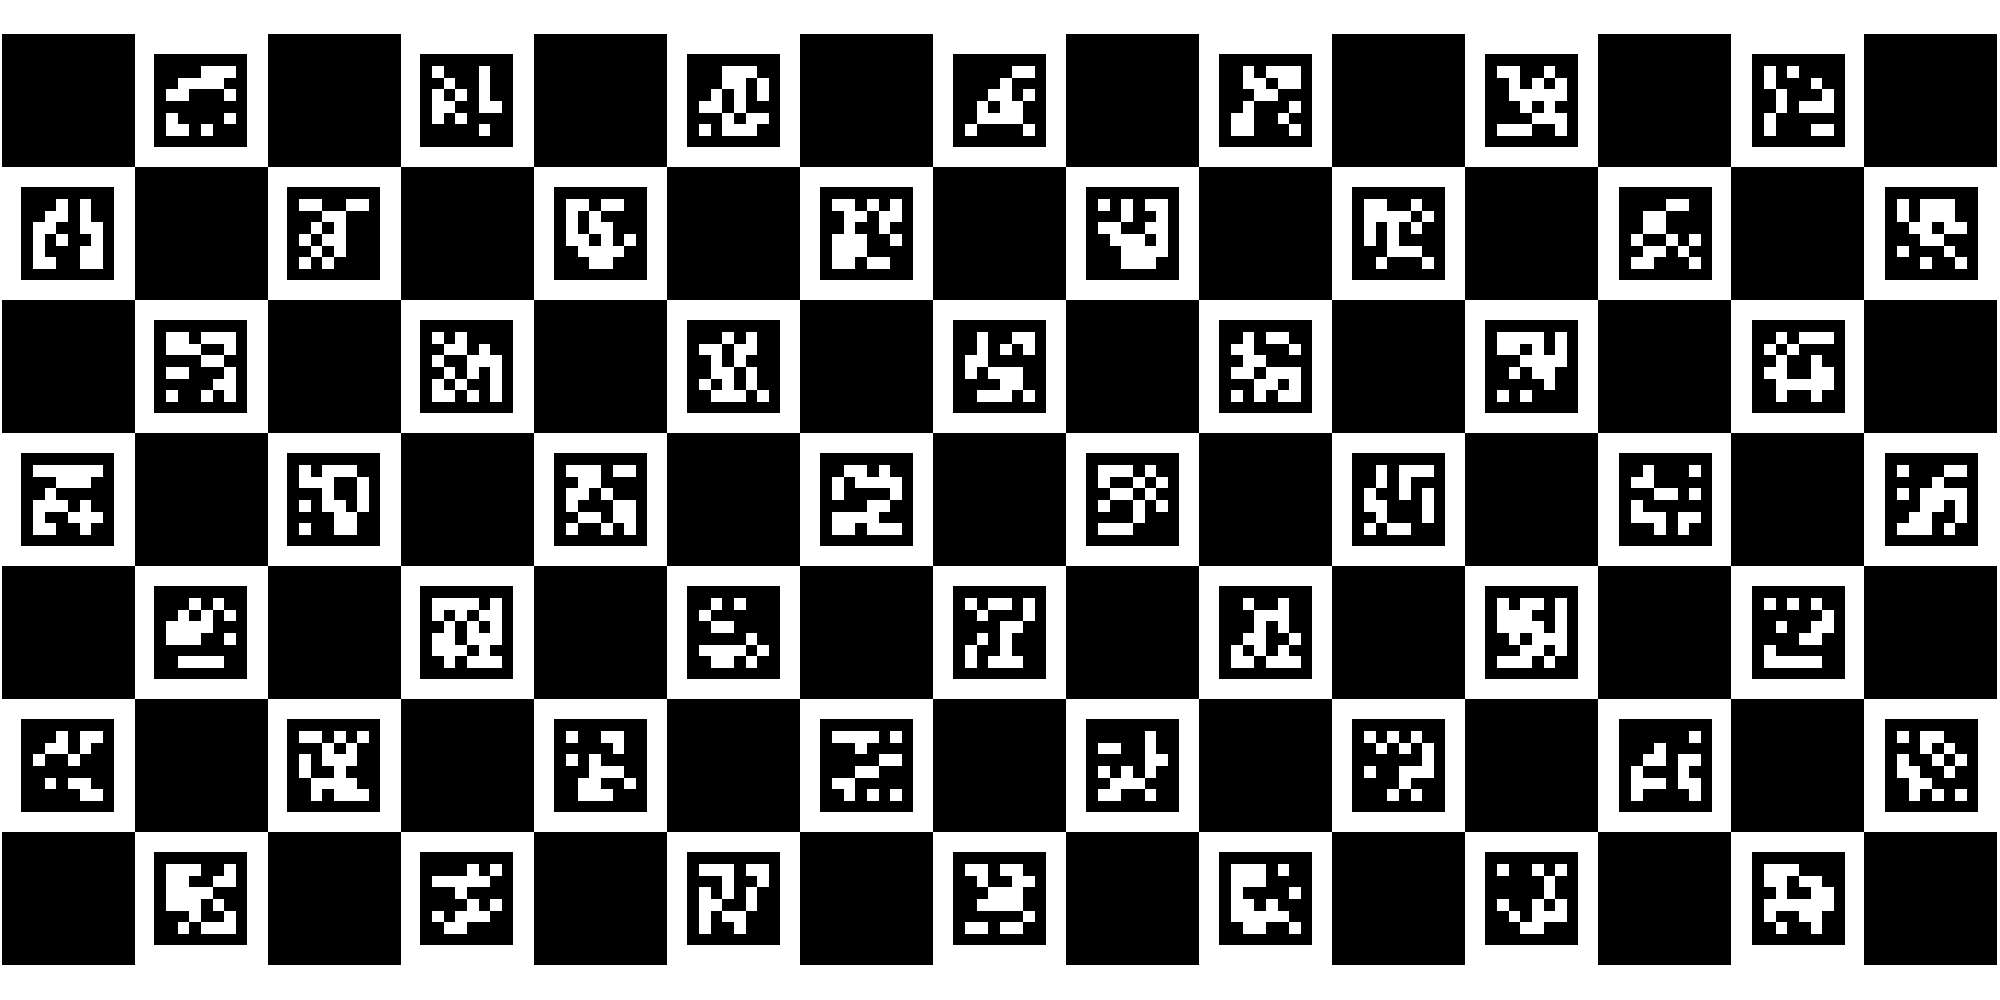

In [29]:
PATH_TO_BOOTSTRAP = '/tmp/bootstrap_markers.png'

# Note that we start the board at 2 * NUM_MARKERS_TO_GENERATE to ensure no conflicts with
# The other markers on the mirror
board = ArucoCalibrationBoard(2000, 1000, field.aruco_dict_id, 15,
                              lowest_marker_id=NUM_MARKERS_TO_GENERATE * 2,
                              target_padding_ratio=0.3)
board.to_png(PATH_TO_BOOTSTRAP)
Image.fromarray(board.image)

## Taking pictures

1. Place the bootstrap board in the center of the mirror (where you would place an object to capture. No need to glue the marker, just make sure the paper is as flat as possible.
2. Take many pictures from various angles (but nothing crazy we need to be able to clearly identify the markers
3. On each picture you want to be able to see the bootstrap board (or at least a good chunk of it). If you feel you have to get too far and your focus distance is innapropriate (even with a large F number) then it's perfectly ok to change the focus (but fix it for the whole process) and run a separate lens calibration with this different focus distance (See notebook `2 - Lens Calibration`).

**Notes:**
- Make sure you have each marker visible on at least a couple pictures
- I've had extremely good results with 30 images

## Some input from you

Before we can start calibrating the mirror we will need some information from you:



In [36]:
# A calibration of the lens at the focus distance you used to take the pictures above
# See the notebook related to lens calibration if you wonder what this is
LENS_CALIBRATION_FILE = '/data/keoscope/calibration_R6mk2/50mm-f1.8-focus-far.json'


# A pattern that matches the images you took for this calibration procedure
CALIBRATION_IMAGES_PATTERN = '/data/keoscope/calibration_R6mk2/mirror_measurements/*.CR3'


# The thickness of the glass layer in front of the mirror itself (usually an aluminium sheet)
# If you have a first surface mirror you can put a small value and IOR of 1 below.
# To be honest I never tried it, I don't have the budget for such a mirror.
MIRROR_THICKNESS_MM = 3


# The index of refraction of the medium in front of the reflective layer
# For glass we usually use 1.5
# We don't recommend acrylic mirrors but Sapphire is ok
# If know how to do it and have the time of course its better to measure
# the thickness and IOR optically.
MIRROR_IOR = 1.5

# These are the marker IDs that you glued on the 4 corners of the mirror
# We will use them to map the overall size of your mirror.
# PLEASE PLEASE: enter them in clockwizse order or the mirror will be flipped !!
MARKER_CORNERS_ID_CLOCKWISE = [0, 4, 46, 12]

# These are the markers that surround the center of the mirror. The origin of the
# coordinate system will be the midpoint between those two. And where you will have to
# place your objects under test
CENTER_DEFINING_MARKERS = [32, 10]


# This is the thickness of what you printed the markers on. It is the how much the ink
# sticks out from the mirror.
# Warning: This is the distance to the medium in front of the mirror (glass), so do not
# add MIRROR_THICKNESS_MM to it
# For paper with glue 0.15mm is a good guess
MARKER_PAPER_THICKNESS_MM = 0.15


# This is the size of physically printed **bootstraping** board. This dimension should be
# the width of a tile of the checkerboard. For more accuracy you can measure more than
# one tile and divide.
CHECKBOARD_TILE_WIDTH_MM = 16.5


## Fitting the location of each marker

Now that you have all the pictures taken we will load them and identify the location of each marker on the mirror

In [47]:
all_images = glob(CALIBRATION_IMAGES_PATTERN)
lens = Lens.from_disk(LENS_CALIBRATION_FILE)

result = Mirror.calibrate_from_measurements(all_images, field, board, lens,
                                            CHECKBOARD_TILE_WIDTH_MM,
                                            MIRROR_THICKNESS_MM,
                                            MIRROR_IOR,
                                            MARKER_CORNERS_ID_CLOCKWISE,
                                            CENTER_DEFINING_MARKERS,
                                            MARKER_PAPER_THICKNESS_MM )

mirror, camera_poses, rmse_by_image, rmse_by_marker = result

Load and process images:   0%|          | 0/31 [00:00<?, ?it/s]

Optimizing locations: 0it [00:00, ?it/s]

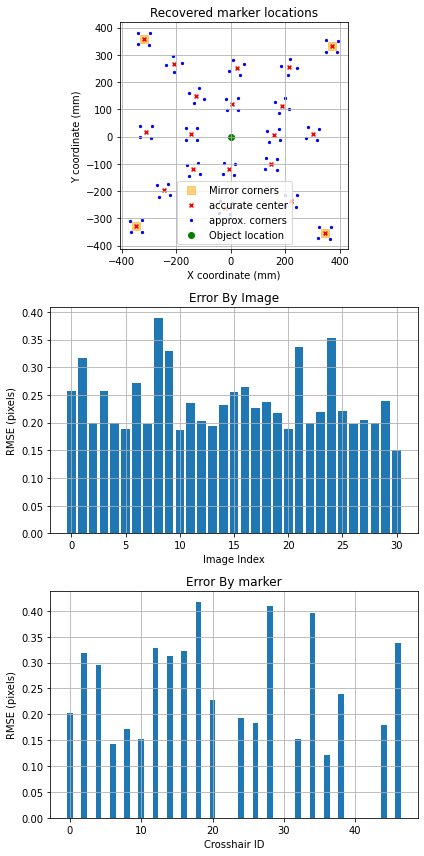

In [48]:
fig, axes = plt.subplots(3, 1)
fig.set_size_inches(6, 12)
axes[0].scatter(*mirror.mirror_corners_clockwise.reshape(-1, 3).T[:2], marker='s', s=50, alpha=0.5, color='orange', label='Mirror corners')
axes[0].scatter(*mirror.crosshair_centers.T[:2], marker='x', s=15, color='red', label='accurate center')
axes[0].scatter(*mirror.crosshair_corners.reshape(-1, 3).T[:2], s=5, color='blue', label='approx. corners')
axes[0].scatter(0, 0, marker='o', label='Object location', color='green')
axes[0].set_title('Recovered marker locations')
axes[0].legend()
axes[0].set_xlabel('X coordinate (mm)')
axes[0].set_ylabel('Y coordinate (mm)')
axes[0].set_aspect('equal')
axes[0].grid()

axes[1].bar(np.arange(len(all_images)), rmse_by_image)
axes[1].set_xlabel('Image Index')
axes[1].set_ylabel('RMSE (pixels)')
axes[1].set_title('Error By Image')
axes[1].grid()

axes[2].bar(mirror.crosshair_ids, rmse_by_marker)
axes[2].set_xlabel('Crosshair ID')
axes[2].set_ylabel('RMSE (pixels)')
axes[2].set_title('Error By marker')
axes[2].grid()
plt.tight_layout()

## Analyzing results

We display above the reprojection errors groupped by image and by marker.

- Check for outliers
- Make sure that all the markers glued on the mirror have been detected by the process

As a rule of thumb anything below 1 pixel should should be good enough. If not it means you are capturing more pixels than the accuracy you are able to achieve so it's a waste of data. Get a better lens or reduce the resolution of your images.

## Saving

If the results look good to you, you can save the results to your location of choice:

In [49]:
mirror.to_disk('/data/keoscope/calibration_R6mk2/mirror_calib.json')